##Moving Average

So far we figured out when a time series is random walk or not and what to do if it is. Now the good questions is that what if after transformation and stationarity being of our time series we autocorrolation. Here comes an updated guidline!

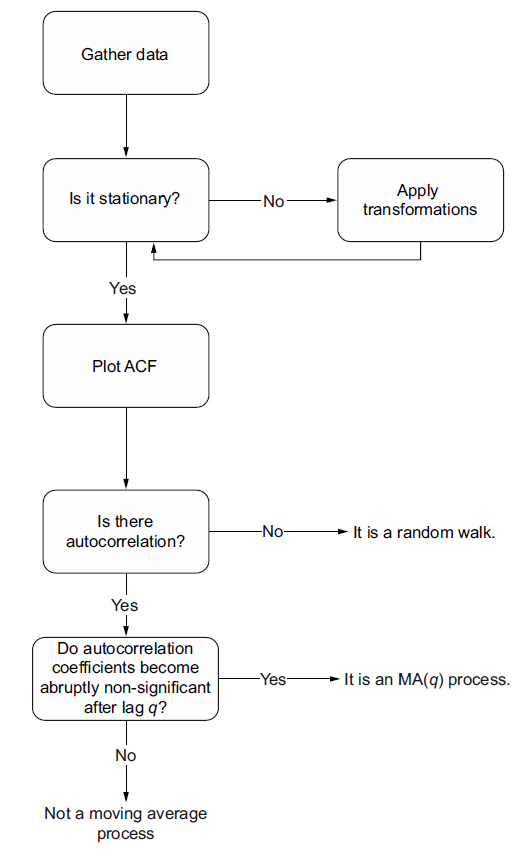

Data of this notebook is from
marcopeix repository and here is the link to data.
https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/data/

###Load Data

In [ ]:
import pandas as pd
df = pd.read_csv('/content/widget_sales.csv')
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


###Visualization

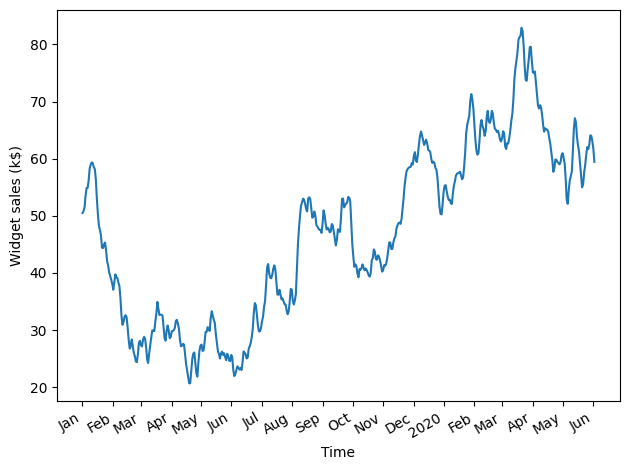

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')
plt.xticks(
[0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439,
 468, 498],
['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

Now that we our data, we go for stationarity checking.

###ADF Calculation

In [ ]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(df['widget_sales'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069359048
p-value: 0.5274845352272605


Result tells us to go for transformation

###Transformation

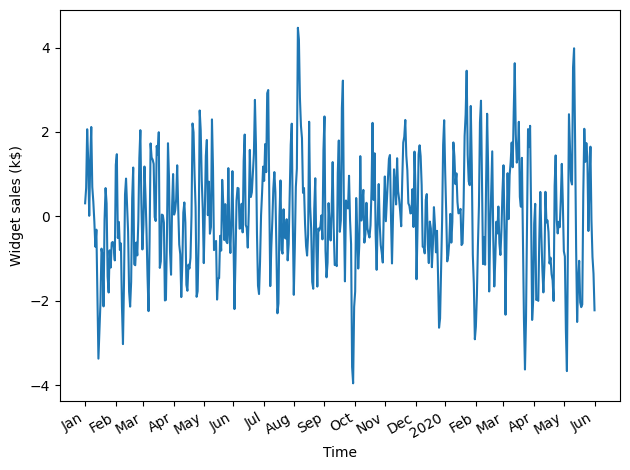

In [ ]:
import numpy as np
widget_sales_diff = np.diff(df['widget_sales'], n=1)
fig, ax = plt.subplots()
ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')
plt.xticks(
[0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439,
 468, 498],
['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

###Recheck Stationarity

In [ ]:
ADF_result = adfuller(widget_sales_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.576657780341959
p-value: 7.076922818587193e-19


Ok we got a stationary time series. Next step according to guidline is to go for ACF plotting.

###ACF Plotting

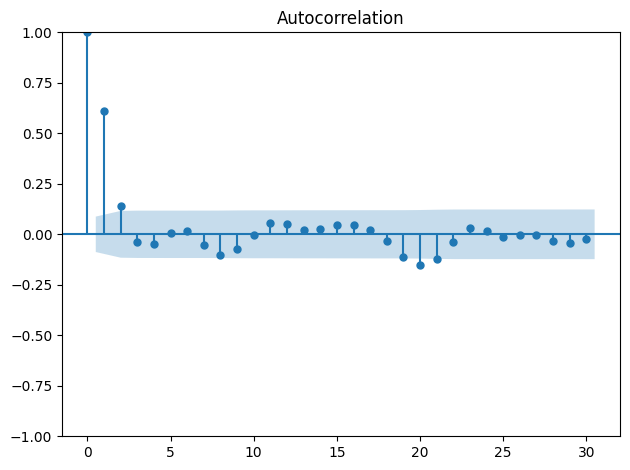

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(widget_sales_diff, lags=30);
plt.tight_layout()

Back to guidline question here:Yes, after 2 lags autocorrolation coefficient disapears.So q=2 here and apparantly we are facing MA(2) process.
MA(q) is calculated like this:

yt = μ + ϵt + θ1ϵt –1 + θ2ϵt –2 +⋅⋅⋅+ θqϵt–q

So what it means that today value depends on previous q days error or that white noise and each of them has its own weight and also it depends on today error and overall mean. That is moving average.

###Train-Test Split

In [ ]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]
print(len(train))
print(len(test))

449
50


We visualize both original and differenced time series.

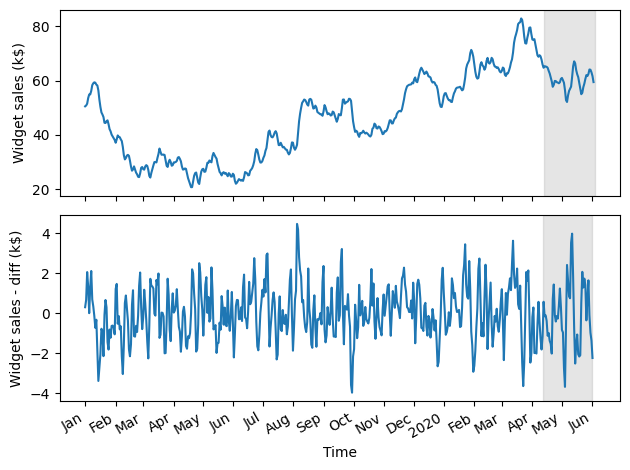

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)
ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)
plt.xticks(
[0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409,
439, 468, 498],
['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

###Define Rolling Forecast

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,
                     window: int, method: str):
  """
  The function takes in a DataFrame containing the full simulated moving
  average process. We also pass in the length of the training set (800 in this
  case) and the horizon of the forecast (200). The next parameter specifies
  how many steps at a time we wish to forecast (2).
  Finally, we specify the method to use to make forecasts.
  """
  total_len = train_len + horizon
  if method == 'mean':
    pred_mean = []
    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i].values)
      pred_mean.extend(mean for _ in range(window))
    return pred_mean
  elif method == 'last':
    pred_last_value = []
    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last_value.extend(last_value for _ in range(window))
    return pred_last_value
  elif method == 'MA':
    pred_MA = []
    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(0,0,2))
      # The MA(q) model is part of the more complex SARIMAX model.
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      # The predicted_mean method allows us to retrieve the actual value of the forecast as defined by the statsmodels library.
      pred_MA.extend(oos_pred)
    return pred_MA

###Prediction with naive and MA models:

In [ ]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA
pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


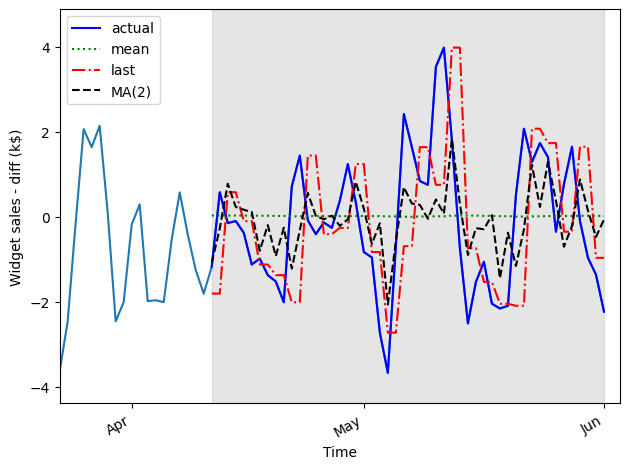

In [ ]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498],
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

###Calculating Metrics

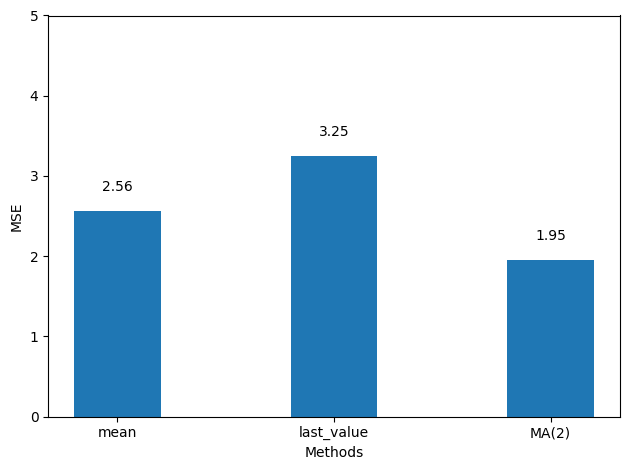

In [ ]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

Now the point is that these calculation is on transformed or differenced data. In order to reverse this condition we should do Invers-Transform that in this case is a simple cumulative.

###Inverse Transform Differneced Data

<ipython-input-22-418e6a231b6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()


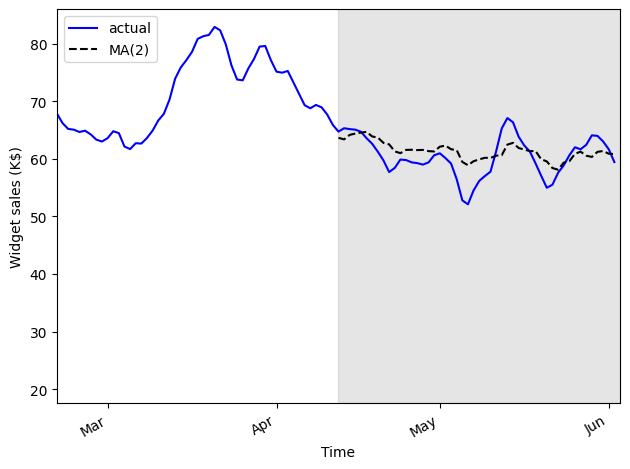

In [ ]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()
fig, ax = plt.subplots()
ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')
ax.axvspan(450, 500, color='#808080', alpha=0.2)
ax.set_xlim(400, 500)
plt.xticks(
[409, 439, 468, 498],
['Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

In the business it is important to report on true value not the transformed on. Keep in mind.

In [ ]:
from sklearn.metrics import mean_absolute_error
mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
print(mae_MA_undiff)

2.3244709244596082


So until now we figured out MA can model time series when the autocorrolation become abruptly insignificant after lag q. but what if we see some sinusoidal pattern? stay tuned.

But before we continue, Did you know we can simualte time series with MA process?

###Create ARMA Data

We will generate 1000 samples with following process:
yt = 0.9 θ
(t –1) + 0.3 θ
(t –2)

In [24]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
np.random.seed(42)
ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])
MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

In [25]:
df = pd.DataFrame({'data': MA2_process})
df.head()

,data
0,0.496714
1,0.308778
2,0.672265
3,2.064470
4,1.330880


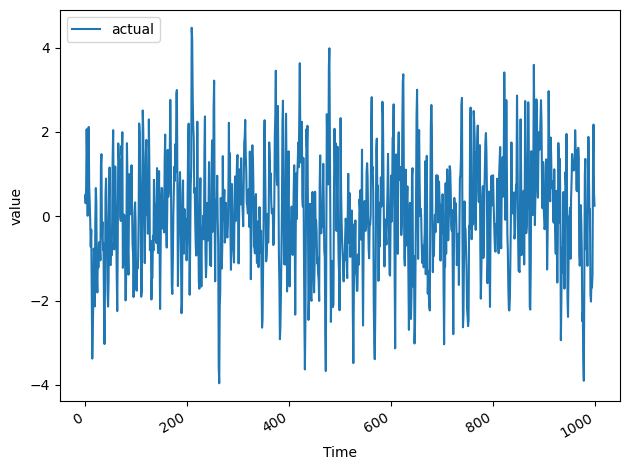

In [27]:
fig, ax = plt.subplots()
ax.plot(df['data'], label='actual')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('value')
fig.autofmt_xdate()
plt.tight_layout()

###Check if stationary:

In [28]:
ADF_result = adfuller(MA2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -14.005444309194495
p-value: 3.7956016167135026e-26


It is stationary so we plot ACF:

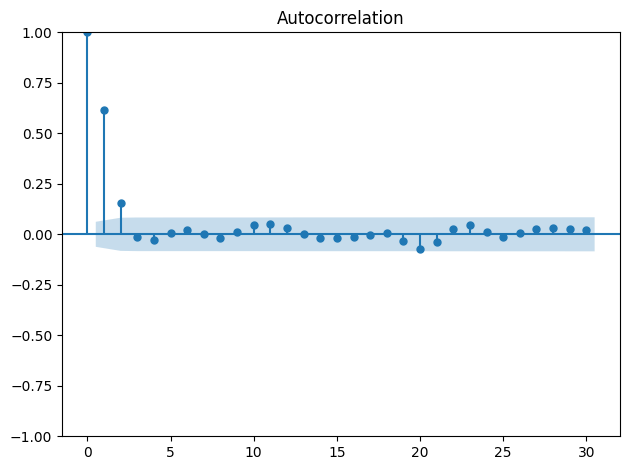

In [29]:
plot_acf(MA2_process, lags=30);
plt.tight_layout()

In [30]:
df = pd.DataFrame({'value': MA2_process})

train = df[:800]
test = df[800:]

In [32]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA2 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

test.loc[:, 'pred_mean'] = pred_mean;
test.loc[:, 'pred_last_value'] = pred_last_value;
test.loc[:, 'pred_MA2'] = pred_MA2;

test.head()

,value,pred_mean,pred_last_value,pred_MA2
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768


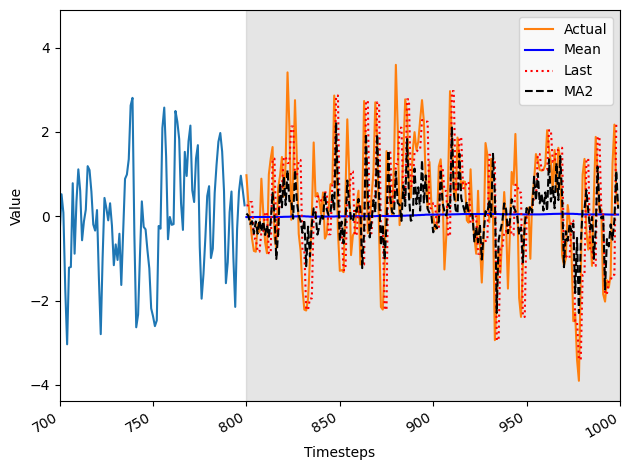

In [33]:
fig, ax = plt.subplots()

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_MA2'], 'k--', label='MA2')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()

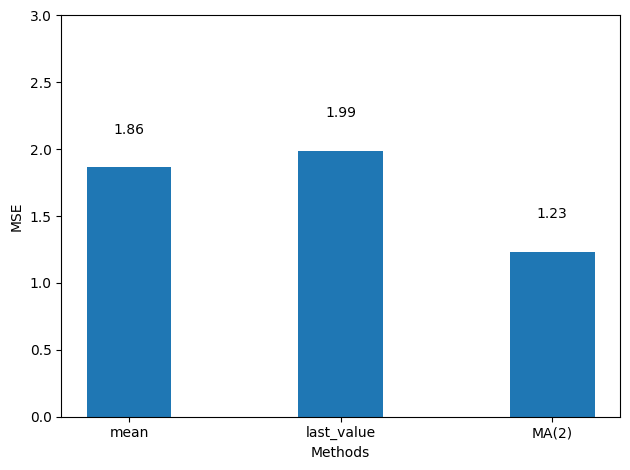

In [34]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_MA = mean_squared_error(test['value'], test['pred_MA2'])
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()